## 10. 階層ベイズモデル
### 10.1 個体差と生存種子数(個体差あり)
個体数100の架空の植物の各個体から8個の種子を採取し、個体$i$における生存種子数$y_i$を調査した。

In [4]:
import pandas as pd

d = pd.read_csv('C:/Users/tanak/study/参考書/データ解析のための統計モデリング/kubobook_2012/glmm/data.csv')
d.head()

,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5


生存種子数のヒストグラムは次のようになり、個体に由来するランダム効果によって過分散が生じている。

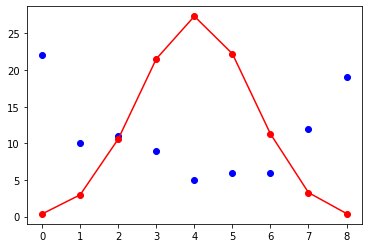

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom

p = binom.pmf(np.arange(9), n=8, p=0.504)*len(d)

plt.scatter(np.arange(9), d.groupby('y')['id'].count(), color='blue');
plt.plot(np.arange(9), p, '-o', color='red');

### 10.2 GLMMの階層ベイズモデル化
個体ごとに由来する原因不明な差異などを組み込んだGLMが**GLMM(階層ベイズモデル)**である。  
しかし、個体差だけでなく場所差なども考慮するGLMMの場合は、パラメータの最尤推定が困難である。  
リンク関数と線形予測子を$logit(q_i)=\beta+r_i$とする。  
$\beta$は全個体に共通するパラメータであり、個体差を表す$r_i$は平均ゼロで標準偏差$s$の正規分布に従うと仮定する。  
データが得られる確率$p(\boldsymbol{Y}|\beta,\{r_i\})$は全100個体の二項分布の積であるから、  
$$
p(\boldsymbol{Y}|\beta,\{r_i\})=\prod_i\begin{pmatrix}8\\y_i\end{pmatrix}q_i^{y_i}(1-q_i)^{8-y_i}
$$
となる。  
推定したい事後分布は、
$$
事後分布 \propto p(\boldsymbol{Y}|\beta,\{r_i\})×事前分布
$$
となるので、事前分布を設定すれば統計モデルの設計は完了する。  
$\beta$の事前分布として無情報事前分布を指定する。  
これは、平均ゼロで標準偏差100の正規分布
$$
p(\beta)=\frac{1}{\sqrt{2\pi×100^2}}\exp{\biggl(\frac{-\beta^2}{2×100^2}\biggr)}
$$
とする。  
個体差$r_i$の事前分布については、平均ゼロで標準偏差$s$の正規分布
$$
p(r_i|s)=\frac{1}{\sqrt{2\pi s^2}}\exp{\biggl(\frac{-r_i^2}{2s^2} \biggr)}
$$
であるとする。  
ここでは、事前分布$p(s)$を無情報事前分布としてよいので、
$$
p(s)=(0から10^4までの連続一様分布)
$$
とする。  
このように、個体差$r_i$の事前分布$p(r_i|s)$のかたちを決める$s$という未知のパラメータがあって、  
さらにこの$s$についても事前分布$p(s)$が設定されているとき、ここでは$p(r_i|s)$を**階層事前分布**と呼ぶ。  
また、パラメータ$s$は**超パラメータ**、事前分布の事前分布である$p(s)$は**超事前分布**と呼ぶ。  
このような階層事前分布を使っているベイズ統計モデルが**階層ベイズモデル**である。

### 10.3 階層ベイズモデルの推定・予測
この例題の階層ベイズモデルの事後分布は、
$$
p(\beta,s,\{r_i\}|\boldsymbol{Y})\propto p(\boldsymbol{Y}|\beta,\{r_i\})p(\beta)p(s)\prod_ip(r_i|s)
$$
と書ける。

In [158]:
import pymc3 as pm


with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sd=100)

    s = pm.Uniform('s', upper=10000, lower=0)
    r = pm.Normal('r', mu=0, sd=s, shape=len(d.y))
    
    y = pm.Binomial('y', p=pm.invlogit(beta + r), n=8, observed=d['y'].values)

# サンプリングして推定する
with model: # Metropolis, HamiltonianMC
    trace = pm.sample(500,
                      start=pm.find_MAP(),
                      step=pm.NUTS(),
                      tune=50, # 最初の100ステップは捨てる
                      init='adapt_diag',
                      chains=4,
                      cores=4,
                      random_seed=0)

# 得られた結果を確認する
#pm.traceplot(trace) # サンプリング過程を表示する
pm.summary(trace) # 推定結果を表示する

<ipython-input-158-ab46a59a3c87>:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(500,
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, s, beta]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 2692 seconds.
The acceptance probability does not match the target. It is 0.9577723055235489, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9310122710043224, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9271459732436286, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9461427115223386, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the m

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,-0.212,0.341,-0.864,0.402,0.020,0.014,282.0,487.0,1.02
r[0],-3.672,1.820,-7.273,-0.796,0.051,0.043,1606.0,910.0,1.01
r[1],-1.847,1.089,-3.861,0.100,0.027,0.021,1739.0,1384.0,1.00
r[2],-0.963,0.920,-2.621,0.704,0.031,0.023,927.0,973.0,1.01
r[3],0.202,0.821,-1.405,1.689,0.026,0.018,991.0,1467.0,1.00
...,...,...,...,...,...,...,...,...,...
r[96],0.757,0.789,-0.776,2.149,0.023,0.017,1213.0,1349.0,1.00
r[97],2.229,1.129,0.354,4.443,0.032,0.025,1421.0,1137.0,1.00
r[98],-0.964,0.907,-2.741,0.624,0.025,0.019,1312.0,1292.0,1.00
r[99],3.997,1.840,0.970,7.440,0.059,0.047,1203.0,897.0,1.00


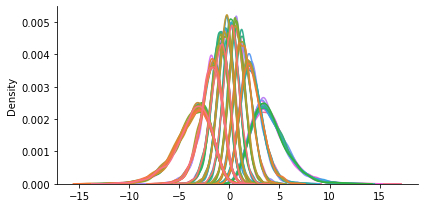

In [184]:
import seaborn as sns

sns.displot(trace.r, kind="kde", legend=False,height=3,aspect=2);

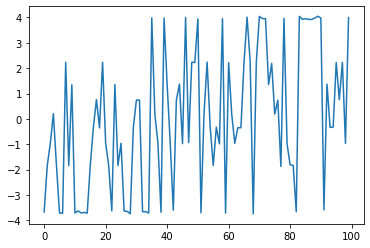

In [183]:
plt.plot(trace.r.mean(axis=0))

In [173]:
?sns.displot

### 10.4 ベイズモデルで使うさまざまな事前分布
あるパラメータとして、無情報事前分布・階層事前分布のどちらを選ぶべきかを考える。  
その選択はそのパラメータがデータ全体のどの範囲を使用しているかに依存すると考えてよい。  
統計モデルには2種類のパラメータが含まれている。
- データ全体を大域的に説明する少数のパラメータ
- データのごく一部だけを説明する局所的な多数のパラメータ

である。  
この例では、切片$\beta$はデータ全体を説明している大域的なパラメータなので、無情報事前分布を用いて推定する。  
一方で、100個ある個体差$\{r_i\}$は、
- 個々の$r_i$はデータ全体のごく一部を説明しているだけ
- 全個体の$\{r_i\}$は「似たような」パラメータのあつまりと考えられる

といった性質を持つ局所的なパラメータであるので、階層事前分布を指定する。  


### 10.5 個体差+場所差の階層ベイズモデル
個体差だけでなく場所差も組み込んだ階層ベイズモデルについて考える。  
今回の実験では、植木鉢(pot)が10個($j\in\{A,B,C,\cdots,J\}$)準備されていて、各植木鉢に10個体の植物が育てられているとする。  
個体番号$i$は、$\{1,2,\cdots,100\}$となっていて、植木鉢Aには$\{1,2,\cdots,10\}$、植木鉢Bには$\{11,12,\cdots,20\}$となるように番号が付けられている。  
$j\in\{A,B,C,D,E\}$の植木鉢は無処理($f_i=0$)、$j\in\{F,G,H,I,J\}$の植木鉢は施肥処理した($f_i=1$)とする。  

In [134]:
d2 = pd.read_csv('C:/Users/tanak/study/参考書/データ解析のための統計モデリング/kubobook_2012/glmm/data6a.csv')
d2.head()

,N,y,x
0,8,1,2
1,8,0,2
2,8,1,2
3,8,2,2
4,8,2,2


観測された個体ごとの種子数$y_i$と処理ごとの平均を図に示す。  
ポアソン分布にしたがうと考えたときに平均が8ぐらいであることから標本標準偏差は$\sqrt{8}$ぐらいになるはずであるが、  
図からそれより大きいことは明らかであり過分散が発生していると考えられる。  
また、植木鉢の差にも原因があることが予想される。  
個体も植木鉢も疑似反復であるので、個体差と植木鉢差を同時に扱う統計モデルを作らなければならない。  
これまでのように個体$i$の種子数$y_i$のばらつきを平均$\lambda_i$のポアソン分布  
$$
p(y_i|\lambda_i)=\frac{\lambda_i^{y_i}\exp{-\lambda_i}}{y_i!}
$$
で表現する。  
線形予測子と対数リンク関数を使って平均種子数$\lambda_i$は、
$$
\log{\lambda_i}=\beta_1+\beta_2f_i+r_i+r_{j(i)}
$$
とする。  
個体差を表す$r_i$は100個、植木鉢の差である$r_{j(i)}$は10個あり、それぞれのばらつきを$s$と$s_p$とする。  
- 大域的な平均パラメータである$\beta_1$と$\beta_2$は無情報事前分布、平均ゼロの押しつぶされた正規分布
- 大域的なばらつきパラメータである$s$と$s_p$は無情報事前分布、$0$から$10^4$の範囲をとる一様分布
- 局所パラメータである$r_i$と$r_{j(i)}$は階層事前分布、平均ゼロで標準偏差はそれぞれ$s$と$s_p$